In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import module
import glob



# User data

 

In [2]:
user_df = pd.DataFrame()

csv_directory = '../user_data'

for filename in os.listdir(csv_directory):
    if filename.endswith(".csv"):
        year = filename.split('.')[0]
        file_path = os.path.join(csv_directory, filename)
        df = pd.read_csv(file_path, delimiter=';',encoding='ISO-8859-1',low_memory=False)
        user_df = pd.concat([user_df, df], ignore_index=True)

# To datetime
user_df['Z36H_LOAN_DATE'] = pd.to_datetime(user_df['Z36H_LOAN_DATE'], format='%Y%m%d', errors='coerce')
user_df['Z36H_RETURNED_DATE'] = pd.to_datetime(user_df['Z36H_RETURNED_DATE'], format='%Y%m%d', errors='coerce')
user_df.dropna(subset=['Z36H_LOAN_DATE'], inplace=True)
user_df['Year'] = user_df['Z36H_LOAN_DATE'].dt.year

# Clean up 2014
mask = user_df['Year'] == 2014
user_df.loc[mask, 'Z30_CALL_NO'] = user_df.loc[mask, 'ï»¿Z30_CALL_NO']
user_df = user_df.drop('ï»¿Z30_CALL_NO', axis=1)

# Drop 2012 because it's incomplete
user_df = user_df[user_df.Year != 2012]

# Calculate Loan time per day
user_df['LOAN_TIME'] = (user_df['Z36H_RETURNED_DATE'] - user_df['Z36H_LOAN_DATE']).dt.days + 1 # min loan time is 1
print('No return date: {}'.format(user_df.Z36H_RETURNED_DATE.isna().sum()))
user_df = user_df.dropna(subset=['Z36H_RETURNED_DATE'])

def generate_bhr_range(start, end):
    start_num = int(start.split('-')[-1])
    end_num = int(end.split('-')[-1])
    return [f"BHR-{i}" for i in range(start_num, end_num + 1)]

def generate_mpg_range(start, end):
    start_num = int(start[3:])  # Remove 'MPG' prefix and convert to int
    end_num = int(end[3:])
    return [f"MPG{str(i).zfill(9)}" for i in range(start_num, end_num + 1)]

# Set of External Users
external_users = set(generate_bhr_range("BHR-529", "BHR-542") +
                     generate_mpg_range("MPG000012868", "MPG000012889") +
                     generate_mpg_range("MPG000012891", "MPG000012968") +
                     generate_mpg_range("MPG000013041", "MPG000013044"))


# Pseudonymize the users
unique_users = user_df['Z36H_ID'].unique()
user_pseudonyms = {}

for index, user in enumerate(unique_users):
    if user in external_users:
        user_pseudonyms[user] = f'E-{index}'
    else:
        user_pseudonyms[user] = f'I-{index}'

user_df['Z36H_ID'] = user_df['Z36H_ID'].map(user_pseudonyms)
user_df['usertype'] = user_df.Z36H_ID.apply(lambda x: 'External' if x.startswith('E') else 'Internal')

# Subject from Callnumber
user_df['Subject'] = user_df.Z30_CALL_NO.apply(lambda x: module.get_subject(str(x)))

user_df.to_csv('../users.csv',index=False)


No return date: 8712


In [3]:
user_df.sample()

,Z30_CALL_NO,Z30_COLLECTION,Z30_BARCODE,Z30_INVENTORY_NUMBER,Z30_DESCRIPTION,Z30_NO_LOANS,Z36H_LOAN_DATE,Z36H_RETURNED_DATE,Z36H_ID,Z36H_LOAN_CATALOGER_NAME,Z13_TITLE,Year,LOAN_TIME,usertype,Subject
76311,Wa-DUQ 110-6070,BIB,E004010041ADF843,2008.348,NaN,27.0,2018-02-01,2018-02-01,I-504,SELFCHECK,François Duquesnoy and the Greek ideal,2018,1.0,Internal,Non-Italian Artists


## User data analysis

In [4]:
print('Unique books in dataset: {}'.format(user_df.Z30_CALL_NO.unique().size))
print(f'Number of loans in total: {len(user_df)}')
total_users = user_df.Z36H_ID.unique().size
external_users = user_df[user_df.usertype == 'External'].Z36H_ID.unique().size
internal_users = user_df[user_df.usertype == 'Internal'].Z36H_ID.unique().size
print('Unique users in dataset: {}'.format(total_users))
print(f'External users: {external_users}, internal users: {internal_users}')

Unique books in dataset: 95107
Number of loans in total: 464360
Unique users in dataset: 737
External users: 99, internal users: 638


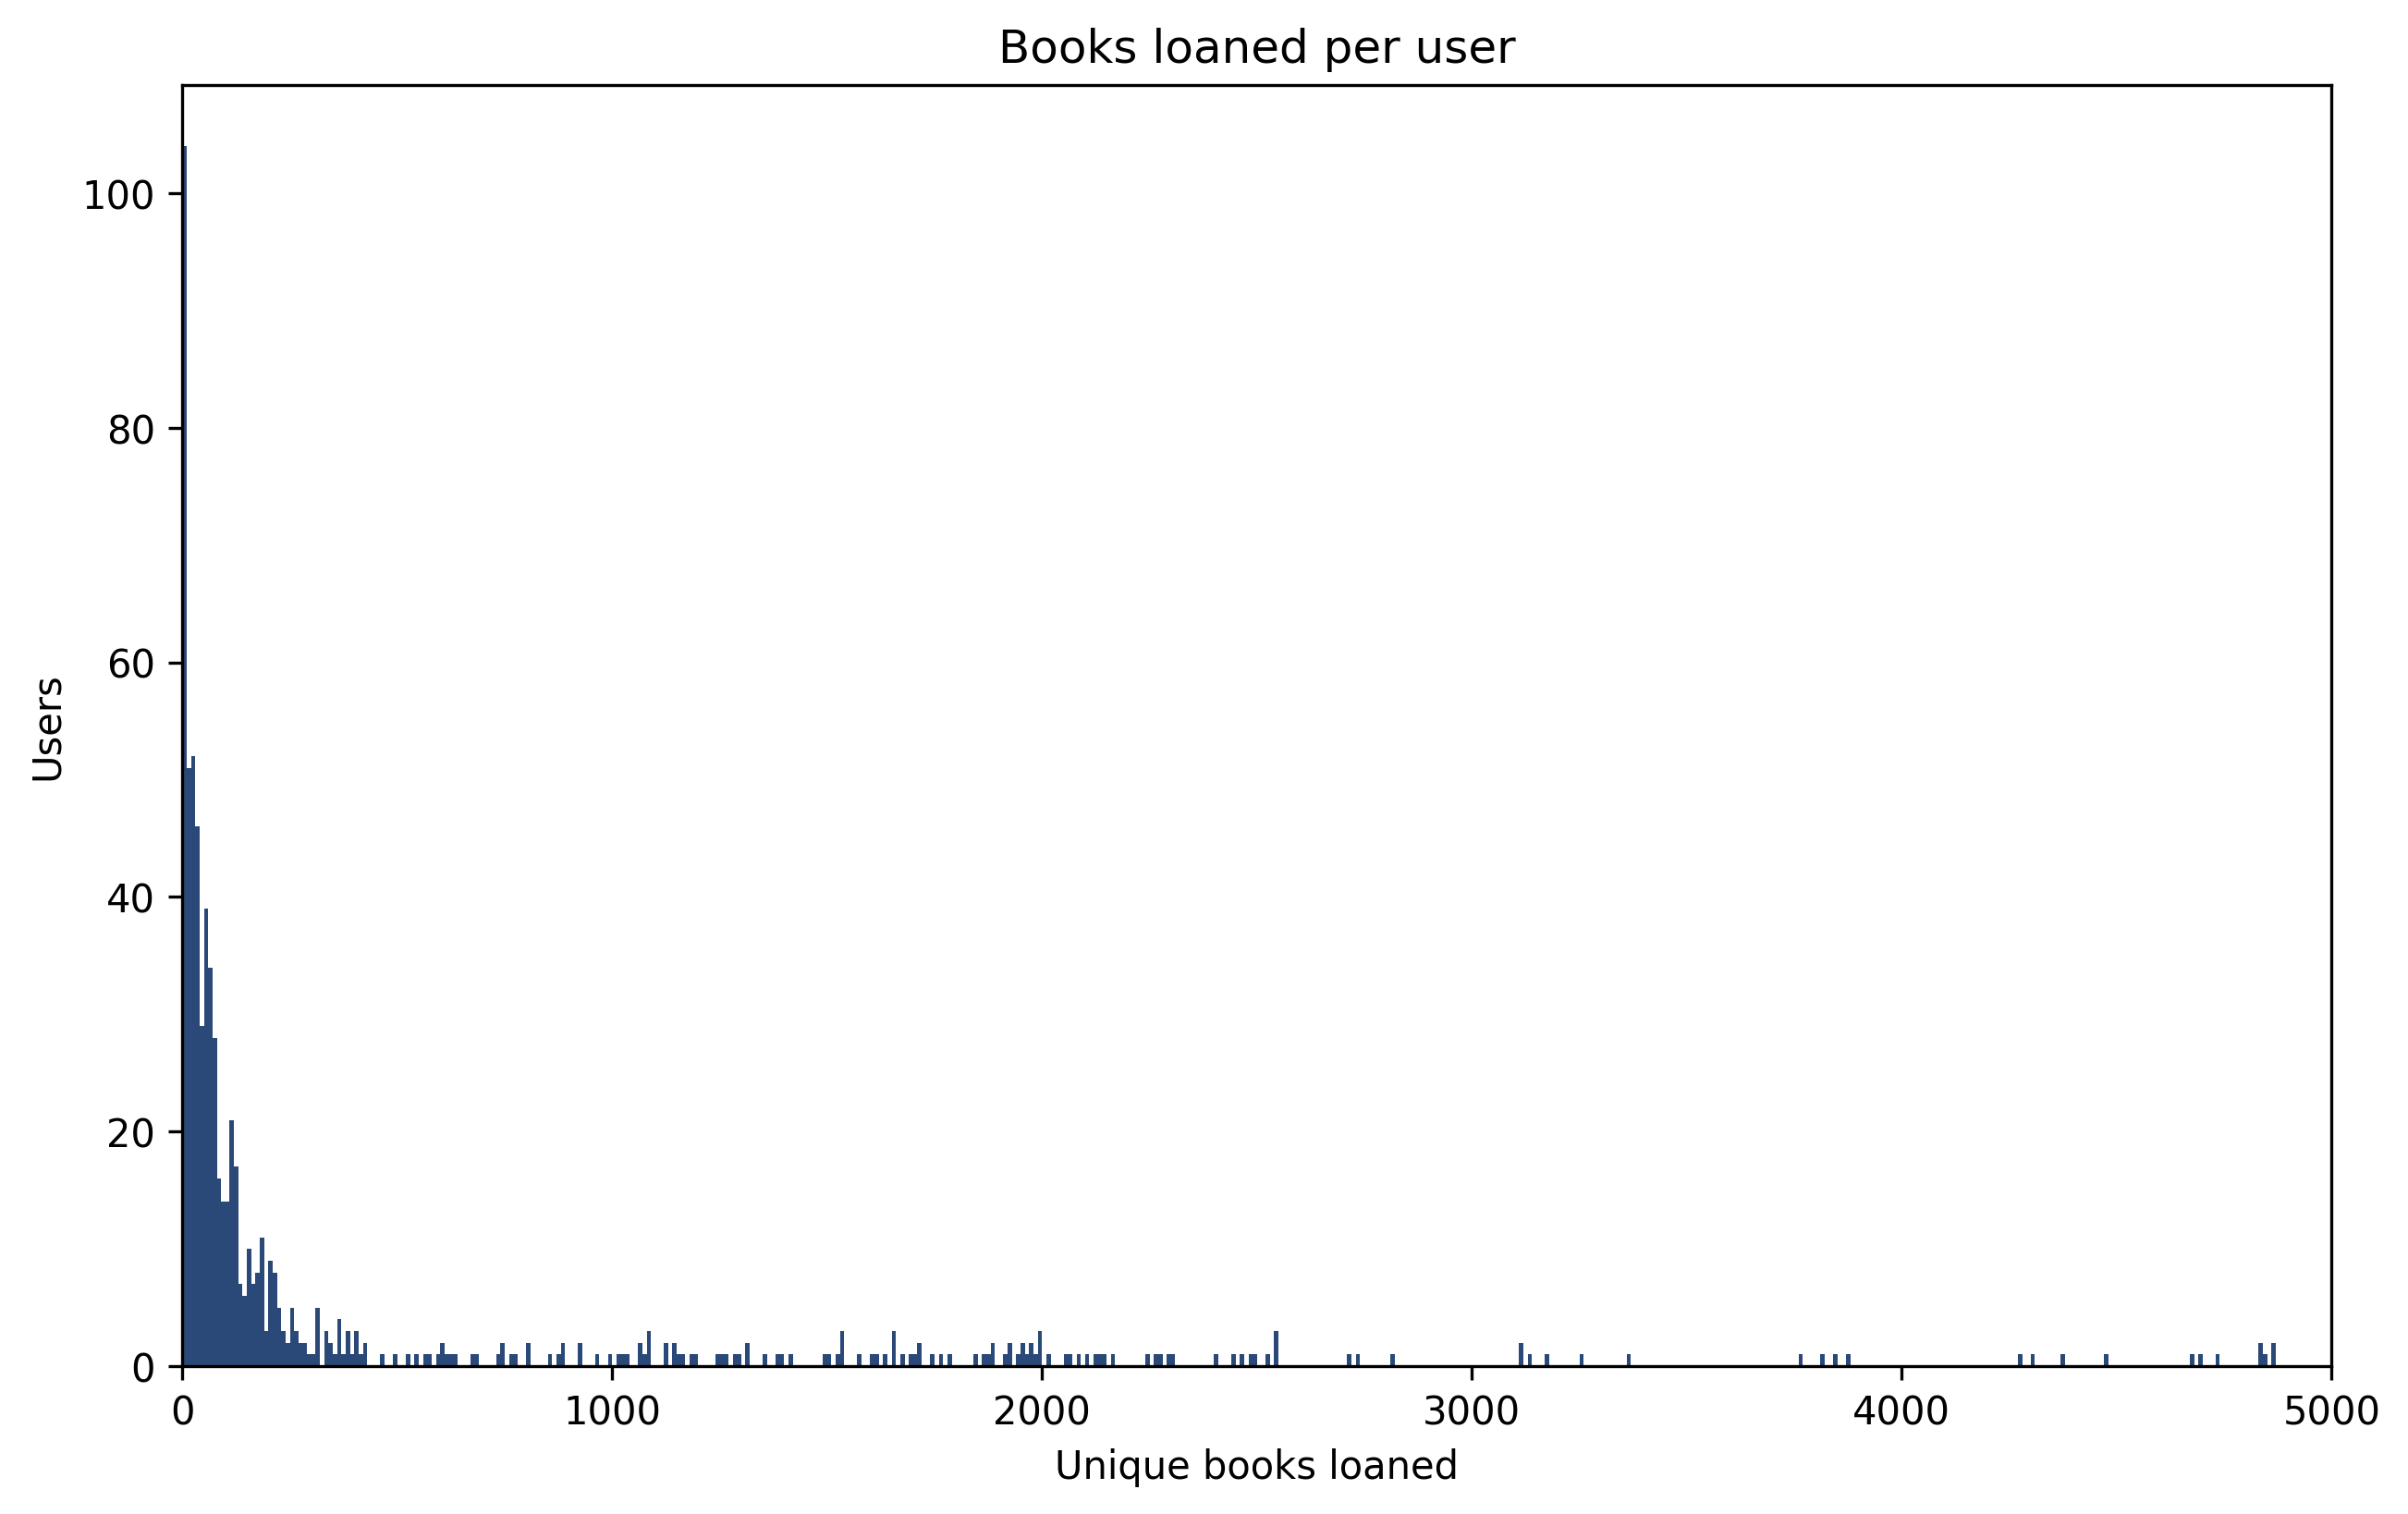

In [5]:
user_book_counts = user_df.groupby('Z36H_ID')['Z30_CALL_NO'].nunique()

# Create a bar plot
plt.figure(figsize=(10, 6), dpi=300)
bins = np.arange(0, user_book_counts.max()+ 1, 10)
plt.hist(user_book_counts, bins=bins, color='#2A4978')
plt.title('Books loaned per user')
plt.xlabel('Unique books loaned')
plt.ylabel('Users') # Set the y-axis limits
plt.xlim(0, 5000)  # Set the x-axis limits
plt.show()

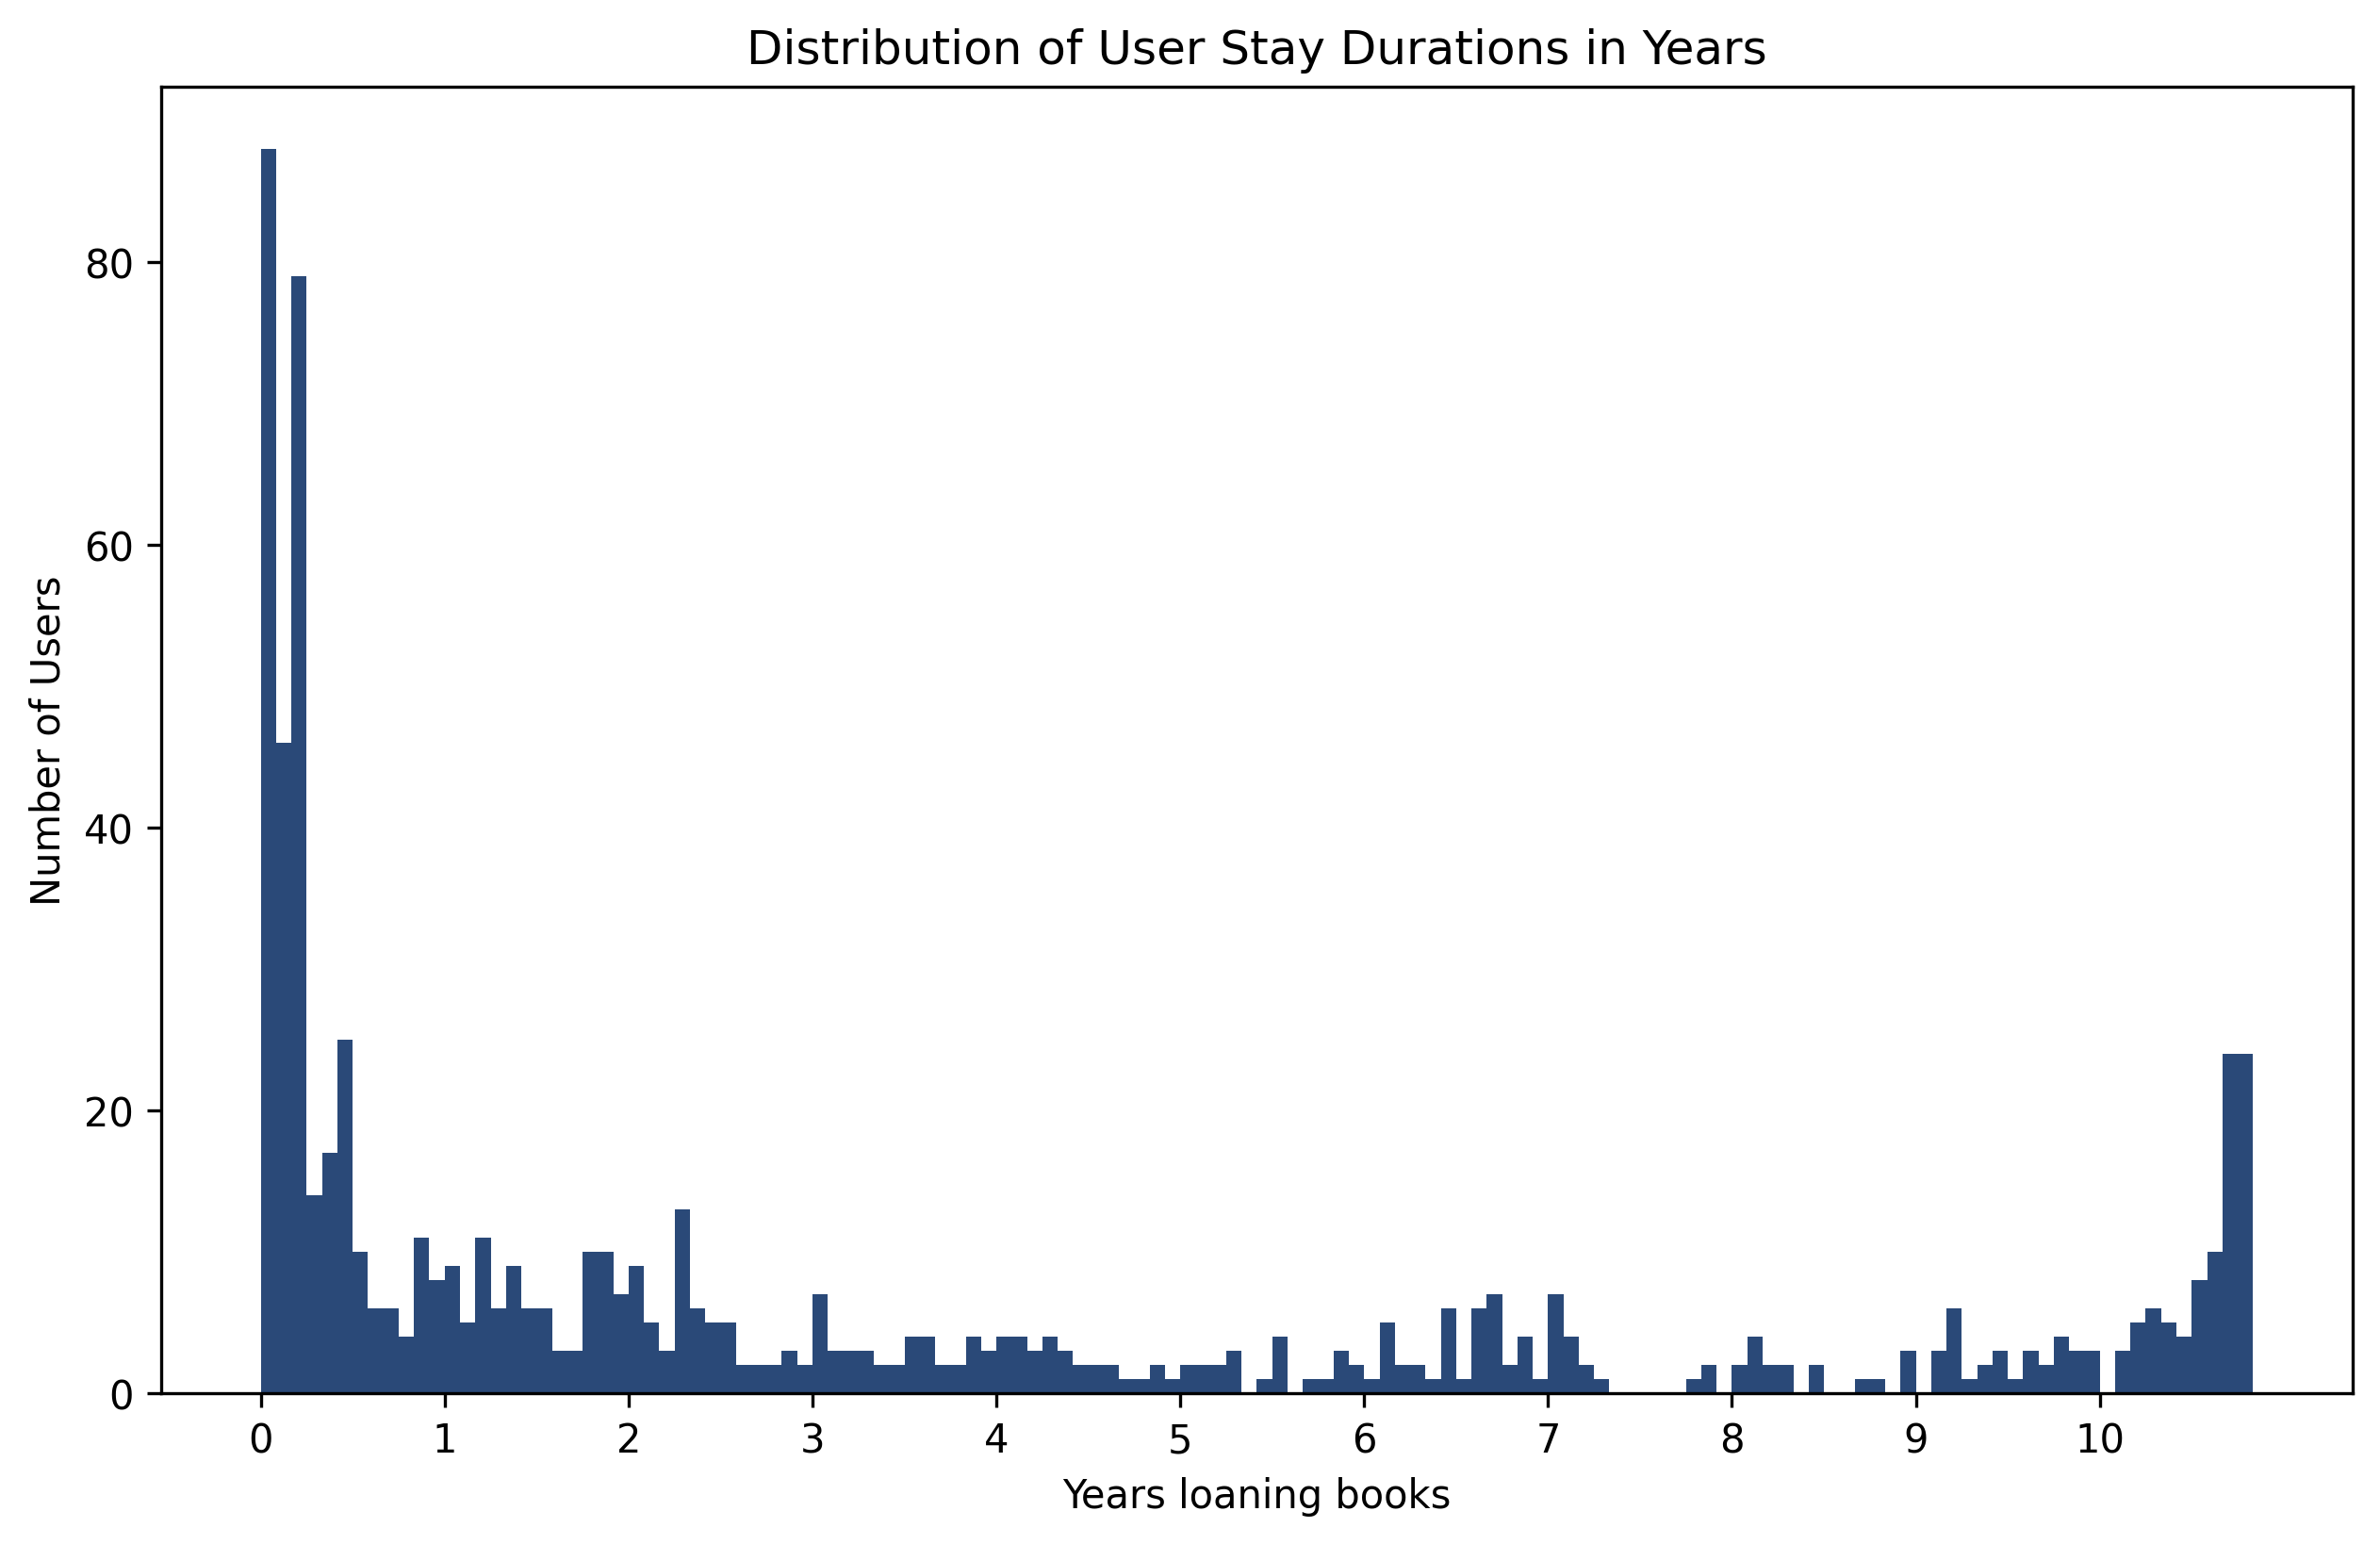

In [6]:
# Calculate the first and last loan dates for each user
user_first_loan_date = user_df.groupby('Z36H_ID')['Z36H_LOAN_DATE'].min()
user_last_loan_date = user_df.groupby('Z36H_ID')['Z36H_LOAN_DATE'].max()

# Calculate the duration of stay in the library for each user in years
user_stay_duration_months = (user_last_loan_date - user_first_loan_date).dt.days // 30 

plt.figure(figsize=(10, 6), dpi=300)
bins = np.arange(0, user_stay_duration_months.max()+ 1, 1)
plt.hist(user_stay_duration_months, bins=bins, color='#2A4978')
plt.title('Distribution of User Stay Durations in Years')
plt.xlabel('Years loaning books')
plt.ylabel('Number of Users')

x_ticks = np.arange(0, (user_stay_duration_months.max() + 1), 12)
plt.xticks(x_ticks, x_ticks // 12)

plt.show()

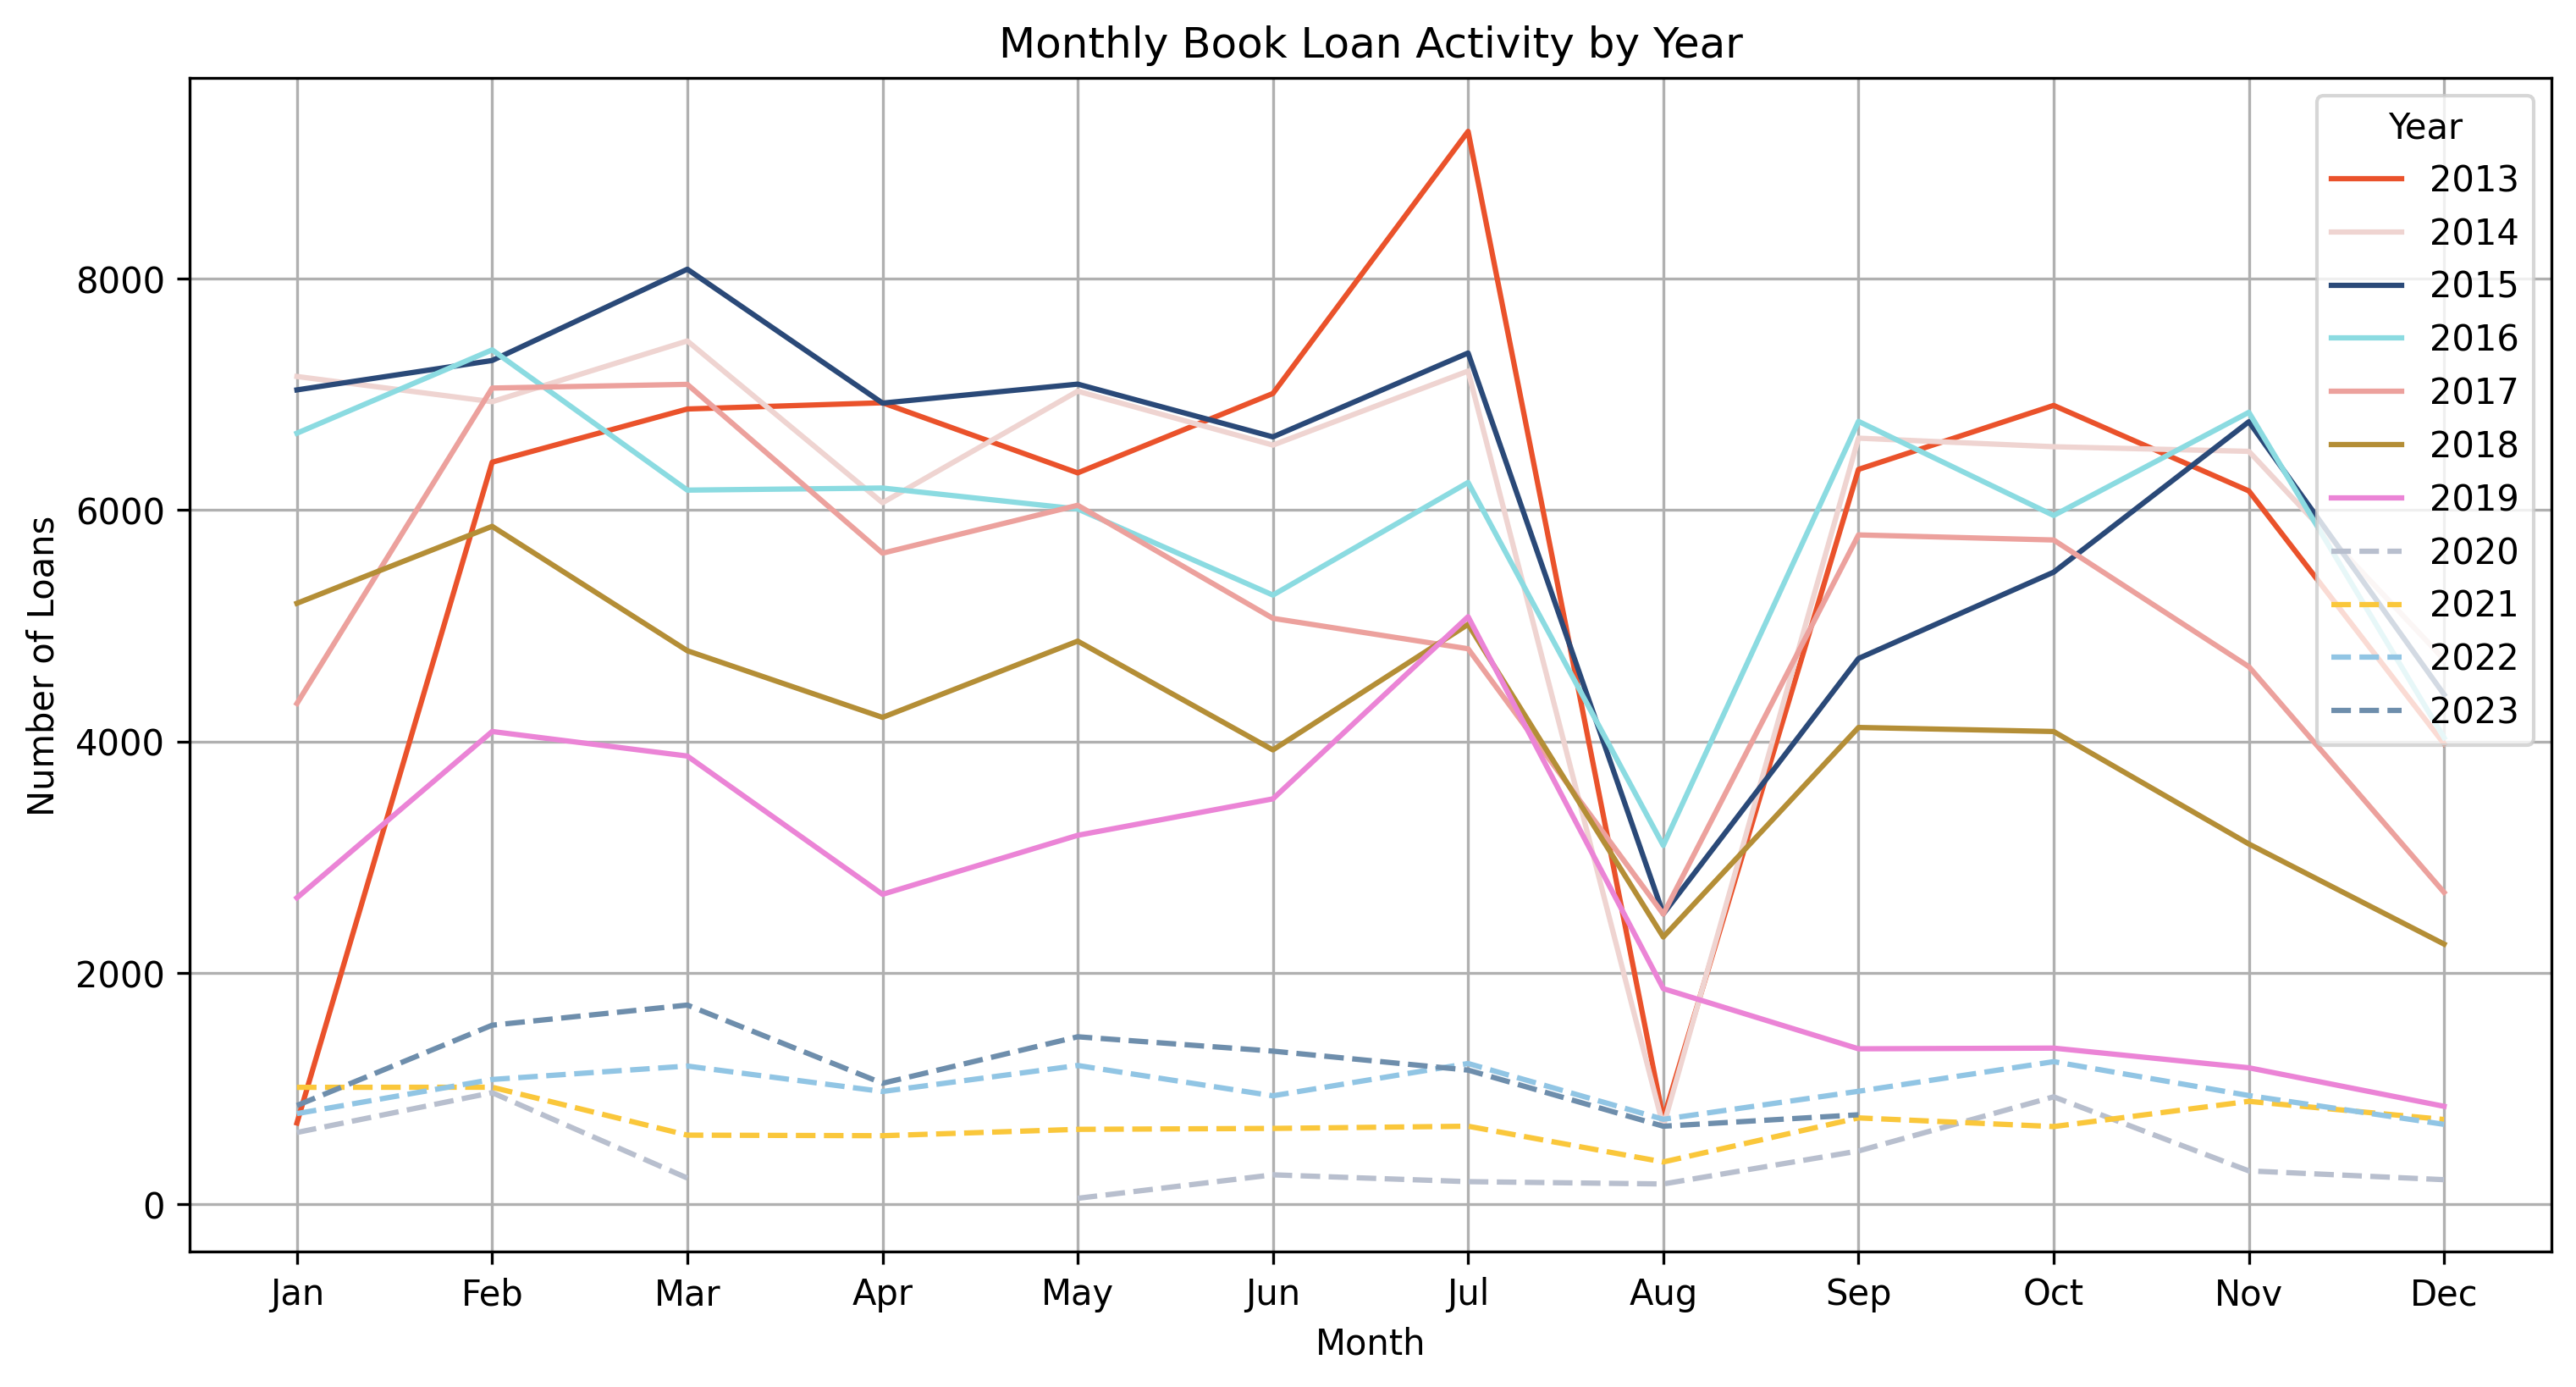

In [7]:

# Map books over time (e.g. a year, when is the library most active, when not so much)
loan_counts = user_df.groupby(['Year', user_df['Z36H_LOAN_DATE'].dt.month])['Z30_CALL_NO'].count().unstack()

# Create a line plot for each year with conditional line styles
plt.figure(figsize=(12, 6), dpi=300)
sns.set_palette(module.CUSTOM_COLOURS)
for year in loan_counts.index:
    linestyle = '-' if year <= 2019 else '--'  # Dotted line for years after 2019
    plt.plot(loan_counts.columns, loan_counts.loc[year], label=f'{year}', linestyle=linestyle)

plt.title('Monthly Book Loan Activity by Year')
plt.xlabel('Month')
plt.ylabel('Number of Loans')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year', loc='upper right')
plt.show()

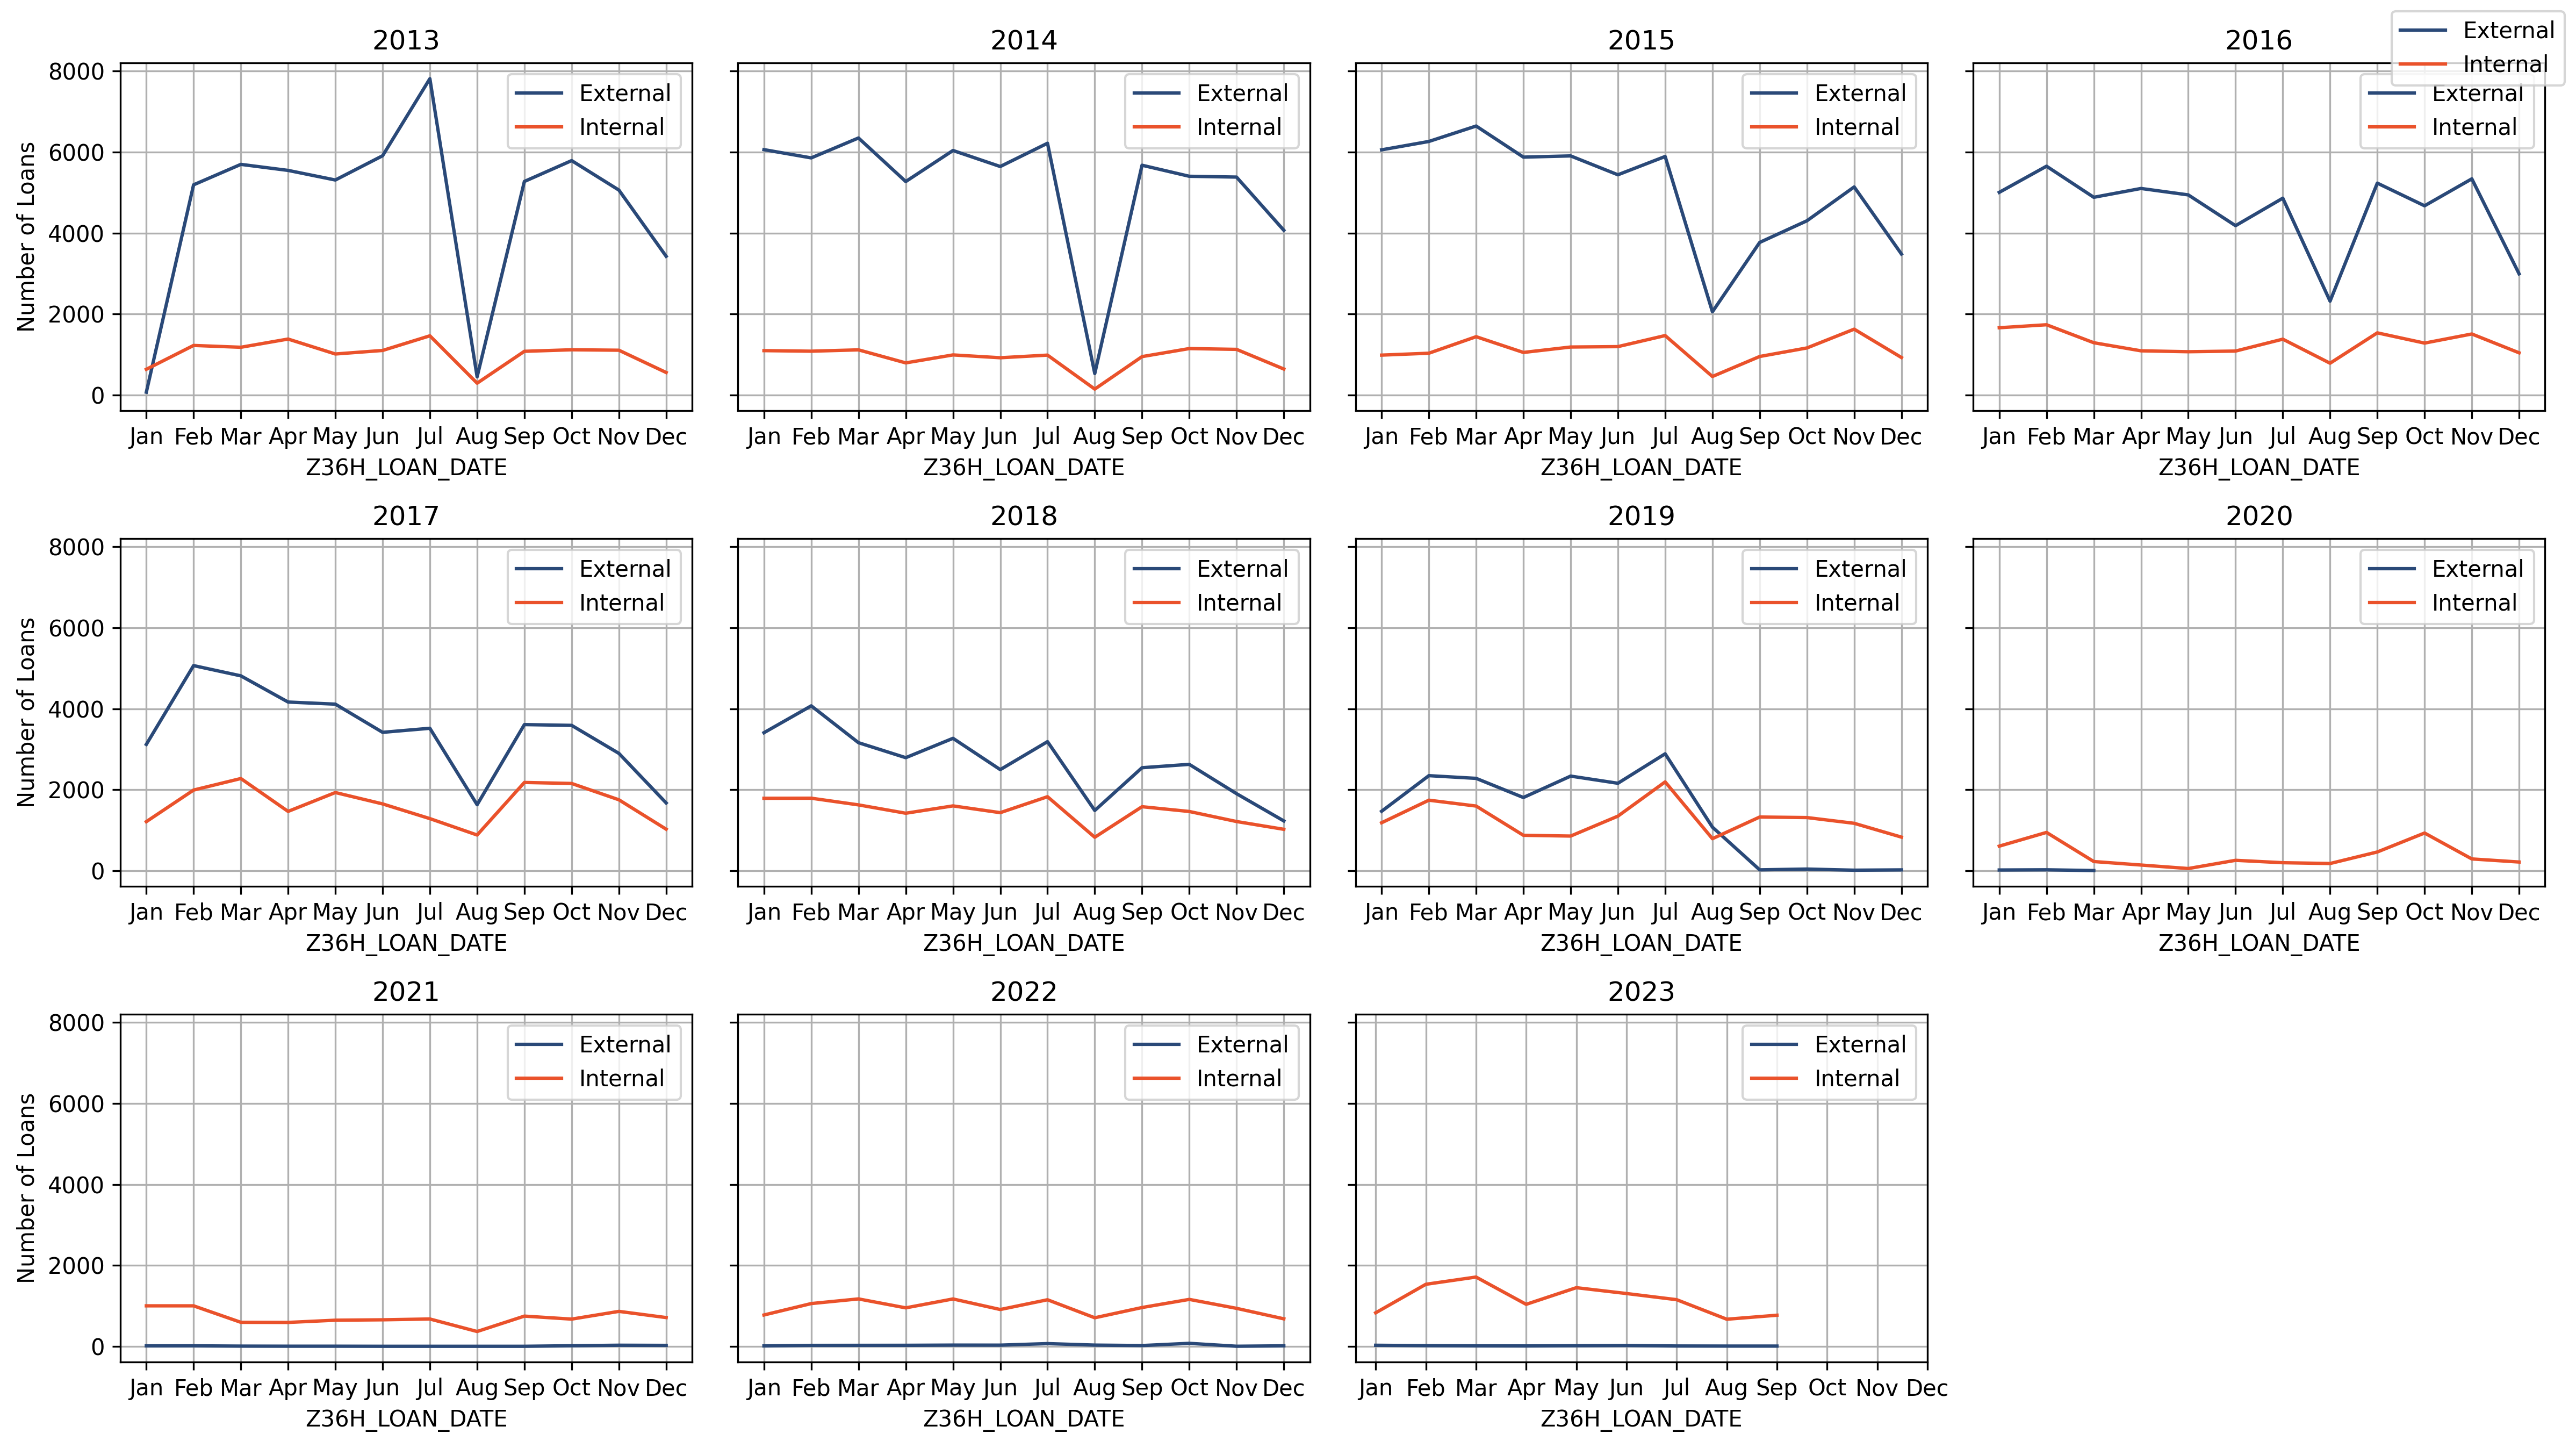

In [8]:
loan_counts = user_df.groupby([user_df['Z36H_LOAN_DATE'].dt.year, user_df['Z36H_LOAN_DATE'].dt.month, user_df.usertype]).Z30_CALL_NO.count()

unique_years = user_df.Z36H_LOAN_DATE.dt.year.unique()
num_rows = (len(unique_years) - 1) // 4 + 1 # subplots
unique_years.sort()
fig, axes = plt.subplots(num_rows, 4, figsize=(16, 3 * num_rows), sharey=True, dpi= 300)  # Share the y-axis limit

for i, year in enumerate(unique_years):
    row, col = i // 4, i % 4
    ax = axes[row, col]

    data_year = loan_counts.loc[year].reset_index()
    ext_data = data_year[data_year.usertype == 'External']
    int_data = data_year[data_year.usertype == 'Internal']

    # Create line plots for internal and external users
    sns.lineplot(data=ext_data, x='Z36H_LOAN_DATE', y='Z30_CALL_NO', ax=ax, color='#2A4978', label='External')
    sns.lineplot(data=int_data, x='Z36H_LOAN_DATE', y='Z30_CALL_NO', ax=ax, color='#EA522B', label='Internal')

    ax.set_title(f'{year}')
    ax.set_ylabel('Number of Loans')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
# Hide empty subplots
for i in range(len(unique_years), num_rows * 4):
    row, col = i // 4, i % 4
    fig.delaxes(axes[row, col])

# To ensure proper spacing
plt.tight_layout()
plt.show()



# Dataframes pre and post 2019

In [9]:
ext_user = user_df[user_df.usertype == 'External']
int_user = user_df[user_df.usertype == 'Internal']

In [10]:
def print_dataset_stats(df, name): 
    print('-----------------------------------------------------')
    print(name)
    print('Unique books in dataset: {}'.format( df.Z30_CALL_NO.unique().size))
    print(f'Number of loans in total: {len(df)}')
    total_users = df.Z36H_ID.unique().size
    print('Unique users in dataset: {}'.format(total_users))
    print('-----------------------------------------------------')


print_dataset_stats(ext_user, 'External Users')
print_dataset_stats(int_user, 'Internal Users')


-----------------------------------------------------
External Users
Unique books in dataset: 77760
Number of loans in total: 324818
Unique users in dataset: 99
-----------------------------------------------------
-----------------------------------------------------
Internal Users
Unique books in dataset: 49289
Number of loans in total: 139542
Unique users in dataset: 638
-----------------------------------------------------


In [11]:
def process_book_df(user_df):

    # Grouping by Book Call number
    grouped = user_df.groupby('Z30_CALL_NO')

    # Total times loaned
    frequency = grouped['Z36H_ID'].count()
    title = grouped['Z13_TITLE'].unique().apply(lambda x: x[0])

    # Unique users who loaned the book
    users = grouped['Z36H_ID'].unique().apply(list)

    # Users weighed on how many times the user loaned the book
    user_book_counts = user_df.groupby(['Z36H_ID', 'Z30_CALL_NO']).size().reset_index(name='COUNT')
    users_weighed = user_book_counts.groupby('Z30_CALL_NO').apply(lambda x: [user for user, count in zip(x['Z36H_ID'], x['COUNT']) for _ in range(count)])

    # Users weighed by loantime (appearing in list as many times as book was loaned in days)
    # users_weighed = grouped.apply(lambda x: sum([[user] * int(days) for user, days in zip(x['Z36H_ID'], x['LOAN_TIME'])], []))

    # Frequency of loan over the years
    years_freq = grouped['Year'].value_counts().reset_index().groupby('Z30_CALL_NO').apply(lambda group: dict(zip(group['Year'], group['count'])))

    # Total time per year (in days) book was loaned
    years_loan_time = user_df.groupby(['Z30_CALL_NO', user_df['Z36H_LOAN_DATE'].dt.year])['LOAN_TIME'].sum().reset_index()
    years_loan_time = years_loan_time.groupby('Z30_CALL_NO').apply(lambda group: dict(zip(group['Z36H_LOAN_DATE'], group['LOAN_TIME'])))

    # Create the output DataFrame
    output_df = pd.DataFrame({
        'frequency': frequency,
        'users': users,
        'users_weighed': users_weighed,
        'yearly_frequency': years_freq,
        'yearly_loan_time': years_loan_time,
        'title': title
    })
    output_df.reset_index(inplace=True)

    # Determine and drop outliers based on frequency threshold
    threshold = 500 # Anything above this value is most probably several editions of the same journal
    output_df['is_outlier'] = output_df['frequency'].apply(lambda x: True if x > threshold else False)
    output_df = output_df[~output_df['is_outlier']].reset_index(drop=True)

    # Yearly frequency normed
    years_df = pd.DataFrame(output_df['yearly_frequency'].tolist()).fillna(0)
    scaler = MinMaxScaler()
    normalized_years_df = pd.DataFrame(scaler.fit_transform(years_df), columns=years_df.columns)
    output_df['yearly_frequency_norm'] = normalized_years_df.apply(lambda x: {year: x[year] for year in years_df.columns}, axis=1)

    # Frequency total normed
    frequency = output_df['frequency'].to_numpy().reshape(-1, 1)
    scaler = MinMaxScaler()
    frequency_scaled = scaler.fit_transform(frequency)
    output_df['frequency_norm'] = frequency_scaled



    return output_df

external = process_book_df(ext_user)
internal = process_book_df(int_user)
full = process_book_df(user_df)

In [12]:
external.to_csv('exp/external.csv',index=False)
internal.to_csv('exp/internal.csv',index=False)
full.to_csv('exp/full.csv',index=False)

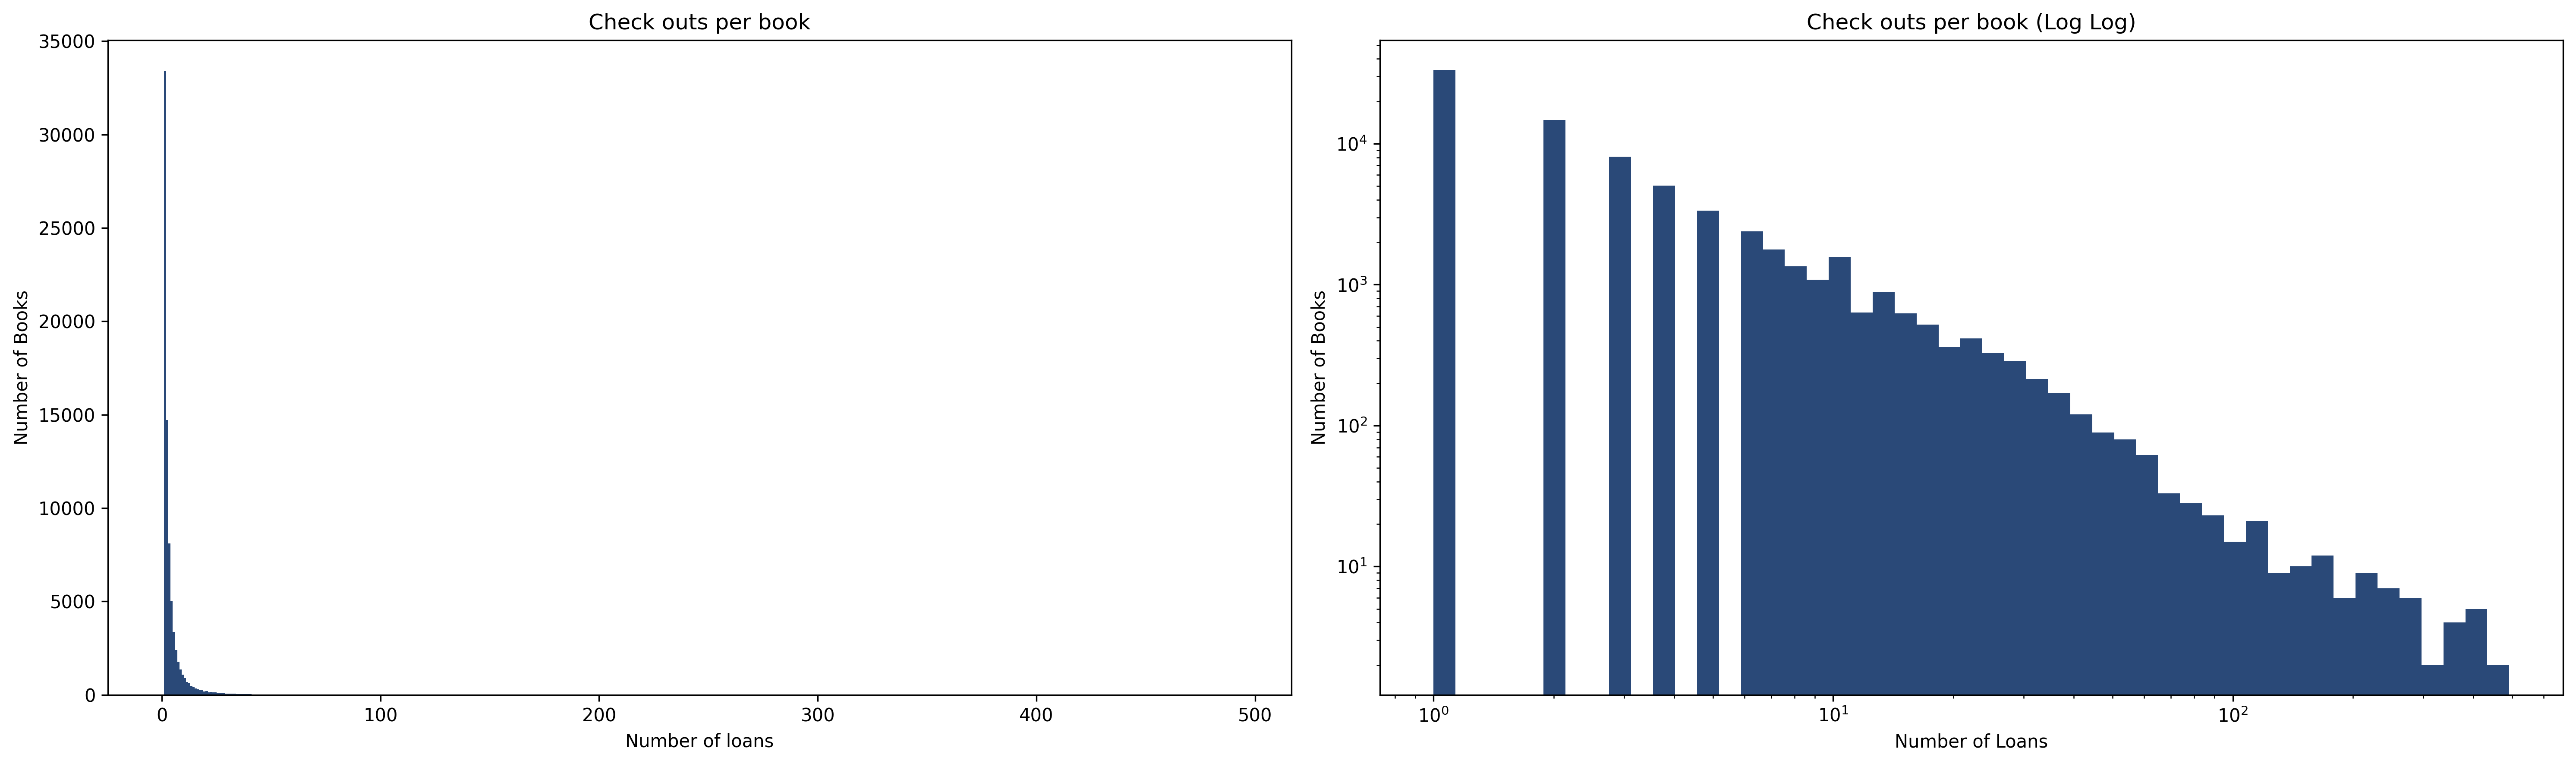

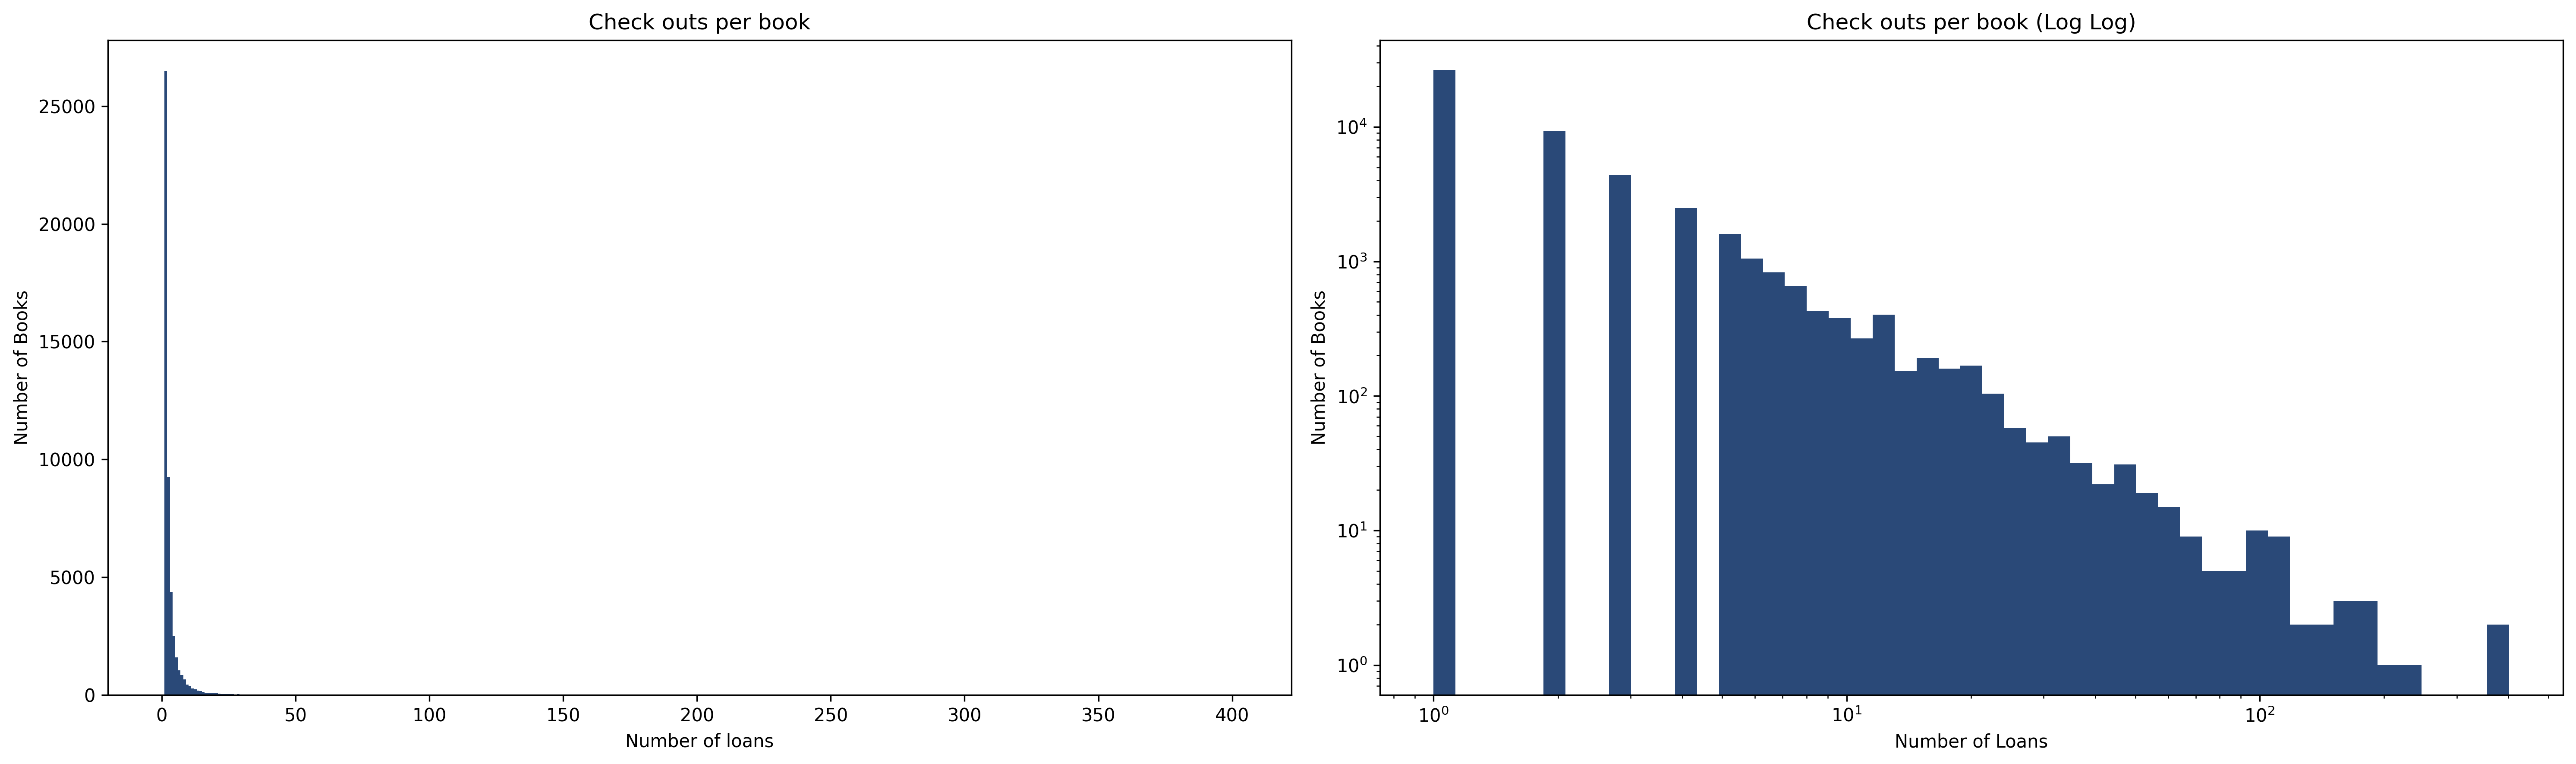

In [13]:
def plot_loan_frequency(df):
    
    max_frequency = df.frequency.max()
    bins = np.arange(0, max_frequency + 1, 1)
    logbins = 10 ** np.linspace(np.log10(df.frequency.min()), np.log10(max_frequency), 50)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=300)

    # Regular Histogram
    ax1.hist(df.frequency, bins=bins, color='#2A4978')
    ax1.set_title('Check outs per book')
    ax1.set_xlabel('Number of loans')
    ax1.set_ylabel('Number of Books')

    # Log Log Plot
    ax2.hist(df.frequency, bins=logbins, color='#2A4978', log=True)
    ax2.set_title('Check outs per book (Log Log)')
    ax2.set_xlabel('Number of Loans')
    ax2.set_ylabel('Number of Books')
    ax2.set_xscale('log')

    plt.tight_layout()
    plt.show()

plot_loan_frequency(external)
plot_loan_frequency(internal)

In [60]:
# Export for rawgraph, loans by subject per year
user_df.groupby(['Subject', user_df['Z36H_LOAN_DATE'].dt.year]).size().reset_index(name='count').to_csv('exp/rawgraph/subject_count_loans.csv', index=False)


# Full bvb export for metadata
path = '../../data/hertziana_exp/b3kat_export/'
files = glob.glob(os.path.join(path, '*.csv'))

li = []

for filename in files: 
    frame = pd.read_csv(filename, header=0)
    li.append(frame)

df_full = pd.concat(li, axis=0, ignore_index=True)

df_full= df_full[['id', 'lang', 'authors', 'parentId', 'title', 'subtitle', 'statement']] # Select columns here
df_full = df_full.drop_duplicates(subset=['id'])

df = user_df.merge(df_full, left_on='Z13_TITLE', right_on='title', how='')
# df = df.drop_duplicates(subset=['Z30_CALL_NO'])

/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_4587/379382171.py:12: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  frame = pd.read_csv(filename, header=0)


In [65]:
df_full = df_full[df_full.parentId.isna()]

In [69]:
df = user_df.merge(df_full, left_on='Z13_TITLE', right_on='title', how='left', validate='many_to_one')

MergeError: Merge keys are not unique in right dataset; not a many-to-one merge

In [68]:
df

,Z30_CALL_NO,Z30_COLLECTION,Z30_BARCODE,Z30_INVENTORY_NUMBER,Z30_DESCRIPTION,Z30_NO_LOANS,Z36H_LOAN_DATE,Z36H_RETURNED_DATE,Z36H_ID,Z36H_LOAN_CATALOGER_NAME,...,Year,LOAN_TIME,Subject,id,lang,authors,parentId,title,subtitle,statement
0,Ha 280-6080,BIB,E004010041AD2DFD,2014.1366,NaN,10.0,2020-08-26,2020-09-02,U-0,SELFCHECK,...,2020,8.0,Iconography,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Va 6400-6090,MAG,E0040100413A8184,2009.4815,NaN,64.0,2020-10-22,2020-11-05,U-1,SELFCHECK,...,2020,15.0,Cultural Institutions,BV035967849,eng,NaN,NaN,The Accademia seminars,NaN,ed. by Peter M. Lukehart
2,KatM-AVI 5720-5760/a,BIB,E004010042EB1ED0,1990.2315,NaN,3.0,2020-09-24,2020-10-06,U-2,SELFCHECK,...,2020,13.0,Catalogues,BV037697165,fre,NaN,NaN,"Avignon, Musée du Petit Palais",NaN,ouvrage publ. sous la dir. d'Esther Moench
3,Hm 9000-6110/1,BIB,E004010043854685,2011.2460,NaN,6.0,2020-09-08,2020-09-10,U-3,SELFCHECK,...,2020,3.0,Iconography,BV023401684,ger,NaN,NaN,Handbuch der politischen Ikonographie,NaN,"Uwe Fleckner, Martin Warnke, Hendrik Ziegler (..."
4,Hm 9000-6110/1,BIB,E004010043854685,2011.2460,NaN,6.0,2020-09-08,2020-09-10,U-3,SELFCHECK,...,2020,3.0,Iconography,BV023401688,ger,NaN,NaN,Handbuch der politischen Ikonographie,NaN,"Uwe Fleckner, Martin Warnke, Hendrik Ziegler (..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634225,Ca-BAR 1880-6130,BIB,E004010043089554,2013.3436,NaN,NaN,2013-12-13,2013-12-17,U-165,KUBA4R01,...,2013,5.0,Italian Artists,BV041269380,ita,NaN,NaN,Barocci in bottega,NaN,a cura di Bonita Cleri
2634226,Ca-CAR 317-6130,BIB,E004010042EB3D31,2013.3860,NaN,NaN,2013-11-25,2013-11-25,U-217,SELFCHECK,...,2013,1.0,Italian Artists,BV041280642,ita,"D'Orazio, Costantino",NaN,Caravaggio segreto,NaN,Costantino D'Orazio
2634227,Hh 2400-6130,BIB,E004010042EB4010,2013.3717,NaN,NaN,2013-12-10,2013-12-10,U-403,SELFCHECK,...,2013,1.0,Iconography,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2634228,Bt 338-6130,BIB,E00401080C577EE3,2013.4131,NaN,NaN,2013-12-11,2013-12-11,U-413,SELFCHECK,...,2013,1.0,Italian Art,BV038177148,ita,"Settis, Salvatore",NaN,Roma fuori di Roma,NaN,NaN
